# 有状态的计算

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/jax/blob/main/docs/jax-101/07-state.ipynb)

*Authors: Vladimir Mikulik*


## Motivation

在机器学习任务中，程序状态通常来自于:
* 模型参数，
* 优化器状态，
* 有状态的神经网络层，比如 [BatchNorm](https://en.wikipedia.org/wiki/Batch_normalization)。

某些JAX转换，比如 `jax.jit`，对输入函数是有约束的，必须是纯函数，不能有副作用，因为副作用只会执行一次（Python代码），后面转换为jaxpr，副作用都被丢弃了.

改变程序的状态也属于副作用，如果函数不能有副作用，又如何更新模型参数、更新优化器状态呢？答案就是使用函数式编程 [functional programming](https://en.wikipedia.org/wiki/Functional_programming).

## 一个简单的例子: 计数器

看一个有状态的程序：计数器

In [1]:
import jax
import jax.numpy as jnp

class Counter:
  """A simple counter."""

  def __init__(self):
    self.n = 0

  def count(self) -> int:
    """Increments the counter and returns the new value."""
    self.n += 1
    return self.n

  def reset(self):
    """Resets the counter to zero."""
    self.n = 0


counter = Counter()

for _ in range(3):
  print(counter.count())

1
2
3


属性 `n` 维护了计数器的状态，当调用`count`时会修改`n`，对函数来说就是副作用。

我们希望`count`函数运行的快点，所以使用了 `jax.jit` 转换。

In [2]:
counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  print(fast_count())

1
1
1


Oh no! 计数器不工作了
```
self.n += 1
```
因为上面这行代码只被执行了一次，也就是在JAX编译这个函数期间。 此外，由于返回值不依赖于`count`的传参，一旦第一次返回1，后面再调用`call`也返回1。

怎么解决这个问题？

## The solution: explicit state

`count`的返回值不依赖函数传参，但是它依赖于一个状态变量`n`啊，是否可以将状态作为函数的传参呢？

In [4]:
from typing import Tuple

CounterState = int

class CounterV2:

  def count(self, n: CounterState) -> Tuple[int, CounterState]:
    # You could just return n+1, but here we separate its role as 
    # the output and as the counter state for didactic purposes.
    return n+1, n+1

  def reset(self) -> CounterState:
    return 0

counter = CounterV2()
state = counter.reset()

for _ in range(3):
  value, state = counter.count(state)
  print(value)

1
2
3


In [5]:
print(counter)

In [6]:
print(state)

3


新版本的 `Counter`, 我们将 `n` 放到了 `count`的参数列表中, 并且返回值增加了更新后的状态，现在我们需要显式记录一个状态变量，虽然麻烦点，但是可以放心的使用`jax.jit`咯

In [7]:
state = counter.reset()
fast_count = jax.jit(counter.count)

for _ in range(3):
  value, state = fast_count(state)
  print(value)

1
2
3


## 一种通用的策略

上面的方法具有普适性，可以把任何的有状态方法都转换为无状态，比如一个有状态的类，

```python
class StatefulClass

  state: State

  def stateful_method(*args, **kwargs) -> Output:
```

转换为无状态

```python
class StatelessClass

  def stateless_method(state: State, *args, **kwargs) -> (Output, State):
```

这是一种常见的 [函数式编程（functional programming）](https://en.wikipedia.org/wiki/Functional_programming) 范式，也是JAX处理状态的方式。比如前面讲过的伪随机数生成，PRNGKey就是状态。

说白了，一个类无状态就是无可变的属性？


## 线性回归🌰

Let's apply this strategy to a simple machine learning model: linear regression via gradient descent.

Here, we only deal with one kind of state: the model parameters. But generally, you'll see many kinds of state being threaded in and out of JAX functions, like optimizer state, layer statistics for batchnorm, and others.

The function to look at carefully is `update`.

In [6]:
from typing import NamedTuple

class Params(NamedTuple):
  weight: jnp.ndarray
  bias: jnp.ndarray


def init(rng) -> Params:
  """Returns the initial model params."""
  weights_key, bias_key = jax.random.split(rng)
  weight = jax.random.normal(weights_key, ())
  bias = jax.random.normal(bias_key, ())
  return Params(weight, bias)


def loss(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> jnp.ndarray:
  """Computes the least squares error of the model's predictions on x against y."""
  pred = params.weight * x + params.bias
  return jnp.mean((pred - y) ** 2)


LEARNING_RATE = 0.005

@jax.jit
def update(params: Params, x: jnp.ndarray, y: jnp.ndarray) -> Params:
  """Performs one SGD update step on params using the given data."""
  grad = jax.grad(loss)(params, x, y)

  # If we were using Adam or another stateful optimizer,
  # we would also do something like
  # ```
  # updates, new_optimizer_state = optimizer(grad, optimizer_state)
  # ```
  # and then use `updates` instead of `grad` to actually update the params.
  # (And we'd include `new_optimizer_state` in the output, naturally.)

  new_params = jax.tree_map(
      lambda param, g: param - g * LEARNING_RATE, params, grad)

  return new_params

Notice that we manually pipe the params in and out of the update function.

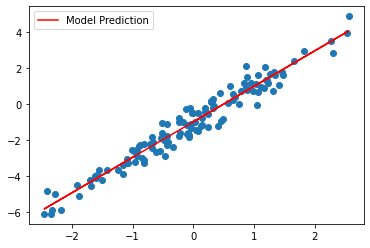

In [7]:
import matplotlib.pyplot as plt

rng = jax.random.PRNGKey(42)

# Generate true data from y = w*x + b + noise
true_w, true_b = 2, -1
x_rng, noise_rng = jax.random.split(rng)
xs = jax.random.normal(x_rng, (128, 1))
noise = jax.random.normal(noise_rng, (128, 1)) * 0.5
ys = xs * true_w + true_b + noise

# Fit regression
params = init(rng)
for _ in range(1000):
  params = update(params, xs, ys)

plt.scatter(xs, ys)
plt.plot(xs, params.weight * xs + params.bias, c='red', label='Model Prediction')
plt.legend();

## Taking it further

The strategy described above is how any (jitted) JAX program must handle state. 

Handling parameters manually seems fine if you're dealing with two parameters, but what if it's a neural net with dozens of layers? You might already be getting worried about two things:

1) Are we supposed to initialize them all manually, essentially repeating what we already write in the forward pass definition?

2) Are we supposed to pipe all these things around manually?

The details can be tricky to handle, but there are examples of libraries that take care of this for you. See [JAX Neural Network Libraries](https://github.com/google/jax#neural-network-libraries) for some examples.